# Report on CrES experiments' results

Initial remarks: the models tested were `facebook/wav2vec2-large-slavic-voxpopuli-v2`, `facebook/wav2vec2-large-960h-lv60-self`, and `classla/wav2vec2-large-slavic-parlaspeech-hr`. HuBERT models were not yet implemented due to incompatibility issues, and with the unusual results we've been getting this hasn't yet gotten the focus it needs. In this notebook I analyze the last run of experiments that were performed on 2022-09-{01,02}, 20 runs in total.

Let's import the results file, calculate macroF1 scores and accuracies, and count total results instances for each model:

In [154]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

test = pd.read_csv("007_test.csv")
dev = pd.read_csv("007_dev.csv")
train = pd.read_csv("007_train.csv")
df = pd.concat([

    pd.read_json("008_results_new_new_new.jsonl", lines=True),
    pd.read_json("009_hubert_training.jsonl", lines=True)
]).reset_index(drop=True)
labels = [
'happiness', 
'neutral', 
'sadness',
'fear', 
'anger', 
]
df["accuracy"] = df.apply(lambda row: accuracy_score(row["y_true"],
                                                     row["y_pred"],
                                                     ), axis=1)
df["macroF1"] = df.apply(lambda row: f1_score(row["y_true"],
                                              row["y_pred"], average="macro", labels=labels), axis=1)
df["model_name_or_path"] = df.model_name_or_path.apply(lambda s: s.split("/")[1])

# Filtering outliers:

df = df[df.accuracy > 0.5]
df.model_name_or_path.value_counts()


wav2vec2-large-slavic-voxpopuli-v2      60
wav2vec2-large-960h-lv60-self           58
wav2vec2-large-slavic-parlaspeech-hr    58
hubert-large-ls960-ft                   22
hubert-xlarge-ls960-ft                  14
Name: model_name_or_path, dtype: int64

The last result has been obtained at:

In [155]:
df.time.dropna().max()

'2022-09-08 08:40:43.325981'

The next cell joins speaker ids and utterance ids to the table of results, which we can use later on for examining per speaker performance.

In [156]:
ids = []
sp_ids = []
for i, row in df.iterrows():
    if "test" in row["split"]:
        ids.append(
            test.utterance_id.tolist()
        )
        sp_ids.append(
            test.speaker_id.tolist()
        )
    else:
        ids.append(
            dev.utterance_id.tolist()
        )
        sp_ids.append(
            dev.speaker_id.tolist()
        )
df["utterance_ids"] = ids
df["speaker_ids"] = sp_ids
for i, row in df.iterrows():
    assert len(row["utterance_ids"]) == len(row["y_pred"])


Let's examine the metrics, grouped by model and split. We can see that all models perform better on dev split if we look at macro F1. We can also see that all models produced non-identical results, this is a bigger problem for 'facebook/wav2vec2-large-slavic-voxpopuli-v2' than it is for 'classla/wav2vec2-large-slavic-parlaspeech-hr' or 'facebook/wav2vec2-large-960h-lv60-self'. In the latter two cases the duplicated predictions only started to appear after 10 runs, and after 20 runs they accumulate 1 and 3 duplicated predictions. For the voxpopuli model this is a problem encountered much sooner and with greater frequency.

In [178]:
def unique(l):
    return len(set([str(i) for i in l]))
gb1 = df[
    (df.split == "test") & 
    
    (df.accuracy > 0.5)].groupby(["model_name_or_path", "split"]).agg(
    {"accuracy": ["mean", "std"],
     "macroF1": ["mean", "std"],
     "y_pred": [unique, "count"]}
)
st = gb1.style.bar(
        vmin=0.63,
        subset=[
            ("accuracy", "mean"),
            ("macroF1", "mean")], 
        cmap="Oranges"
    ).apply(
        lambda row: ['color: red', None] if row[0] != row[1] else [None, None],
        axis=1, 
        subset=[
            ("y_pred", "unique"),
            ("y_pred", "count")]
    ).text_gradient(
        cmap="Oranges",
        subset = [("y_pred", "unique")],
        gmap = -gb1[("y_pred", "unique")]/gb1[("y_pred", "count")]
        )
st

The following cells calculate average performance, grouped by speaker_id and model on the test split.

In [159]:
def get_per_speaker_error_rate(row):
    speakers = row["speaker_ids"]
    y_true = row["y_true"]
    y_pred = row["y_pred"]
    
    df = pd.DataFrame(data={
        "speaker": speakers,
        "y_true": y_true,
        "y_pred": y_pred
    })
    df["correct"] = df.y_true == df.y_pred
    import numpy as np
    return df.groupby("speaker").aggregate({"correct": "mean"  })

correct_breakdown = []

for i, row in df.iterrows():
    correct_breakdown.append(
        get_per_speaker_error_rate(row).correct.to_json()
    )
df["correct_ratio_breakdown"] = correct_breakdown

In [160]:
from ast import literal_eval
s = df[df.split == "test"].correct_ratio_breakdown.apply(literal_eval).apply(pd.Series)        
ndf = s.melt().rename(columns={
    "variable": "speaker",
    "value": "correct_ratio"
})
models = df[df.split=="test"].model_name_or_path.tolist()
new_models = [models[i] for j in range(s.columns.shape[0]) for i in range(s.shape[0])]
ndf["model_name_or_path"] = new_models

On the plot below we can see the percentage of correctly identified instances of individual speakers by different models, with black lines indicating standard deviation. 

For some speakers all models correctly predict their utterances, some speakers are barely correctly predicted by any model, and some speakers are better recognised by some models than others.

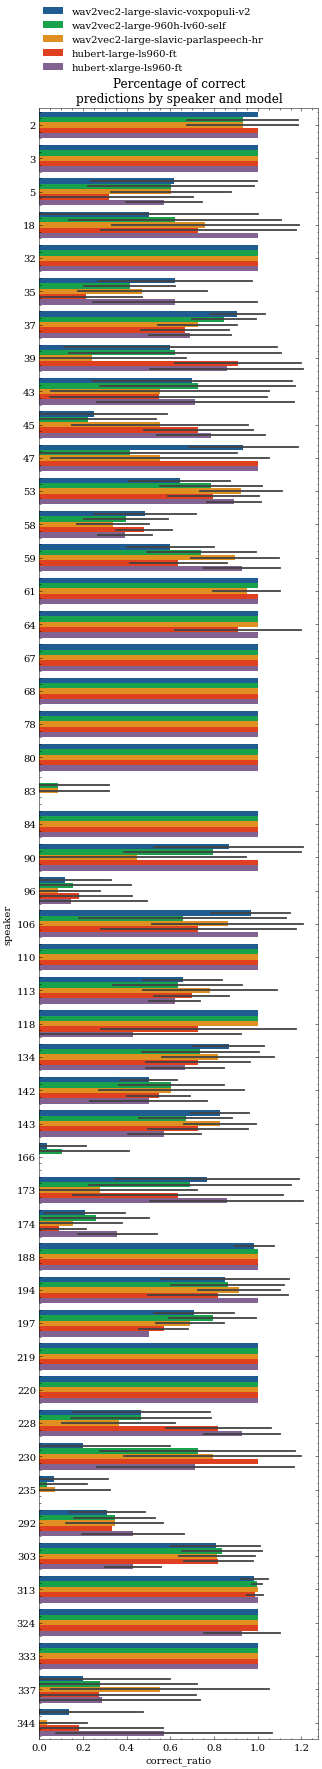

In [161]:
gb = ndf.groupby("speaker").aggregate({
    "correct_ratio": ["mean", "std"]
})
gb.index = gb.index.astype(int)
gb = gb.sort_index()

plt.figure(figsize=(5, 30))
sns.barplot(data = ndf, y = "speaker" , x = "correct_ratio", hue="model_name_or_path", ci="sd")
plt.title("Percentage of correct\npredictions by speaker and model")
plt.legend(loc=(0, 1.02))
plt.xlim((0, None))
# plt.tight_layout()
plt.savefig("images/008_speaker_and_model_correctness.pdf", dpi=200)
plt.show()

For sanity check let's see if we have any leakages between splits speakers:

In [162]:
test_speakers = set(test.speaker_id.tolist())
dev_speakers = set(dev.speaker_id.tolist())
train_speakers = set(train.speaker_id.tolist())

In [163]:
d = {"test_speakers": test_speakers,
     "dev_speakers": dev_speakers, 
     "train_speakers": train_speakers}

for first in d:
    for second in d:
        if first == second:
            continue
        print(f"{first} against {second}: {len(d[first].intersection(d[second]))} leaked")

test_speakers against dev_speakers: 0 leaked
test_speakers against train_speakers: 0 leaked
dev_speakers against test_speakers: 0 leaked
dev_speakers against train_speakers: 0 leaked
train_speakers against test_speakers: 0 leaked
train_speakers against dev_speakers: 0 leaked


# Addendum

To be added:
1. a confusion matrix of an average run of the best-performing system
2. for the same "average run of the best-performing system" test predictions and true labels, in tabular format, with IDs of instances, for human inspection
3. agreement (accuracy, macroF1) between two different systems (choose a few random runs, and then investigate combinations), to see whether the systems agree between each other better than with the true label (could mean they all overfitted in a similar manner, not being able to handle the variation, or rather "weirdness" of some instances, or, rather, speakers)

Let's first see which model is best performing. I will look at average macro F1 on test split to detemine that.

In [164]:
idx = gb1.loc[(slice(None), "test"), ("macroF1", "mean")].idxmax()
best_model = idx[0]
best_model

'hubert-xlarge-ls960-ft'

Let us get the average run of this model:

In [165]:
c1 = df.model_name_or_path == best_model
c2 = df.split == "test"

subset = df[c1&c2]
average_macroF1 = subset.macroF1.mean()
import numpy as np
average_run_idx = (subset.macroF1 - average_macroF1).apply(abs).idxmin()
y_true, y_pred = subset.loc[average_run_idx, ["y_true", "y_pred"]]

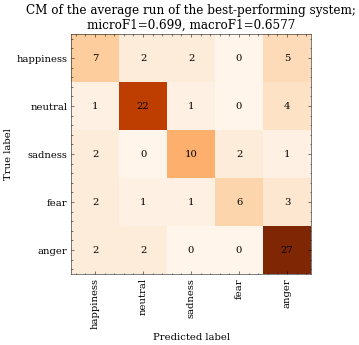

(0.6990291262135923, 0.6576627581581442)

In [166]:
def plot_cm(y_true, y_pred, labels, save=False, title=None):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score
    import matplotlib.pyplot as plt
    plt.style.use(["science", "no-latex", ])
    cm = confusion_matrix(y_true, y_pred, labels=labels, )
    # print(cm)
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    microF1 = f1_score(y_true, y_pred, labels=labels, average ="micro")
    macroF1 = f1_score(y_true, y_pred, labels=labels, average ="macro")

    metrics = f"{microF1=:0.4}, {macroF1=:0.4}"
    if title:
        plt.title(title +";\n" + metrics)
    else:
        plt.title(metrics)
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()
    return microF1, macroF1

plot_cm(labels=labels, y_true=y_true, y_pred=y_pred, 
        title="CM of the average run of the best-performing system",
        save="images/008_CM.png")

In [167]:
y_true, y_pred, utterance_ids = subset.loc[average_run_idx, ["y_true", "y_pred", "utterance_ids"]]
utterance_breakdown = pd.DataFrame({"y_true": y_true, "y_pred":y_pred, "utterance_id": utterance_ids})
utterance_breakdown.to_json("008_utterance_breakdown.jsonl", lines=True, orient="records")

Let's check the accuracy-macroF1 profile for all results on test split:

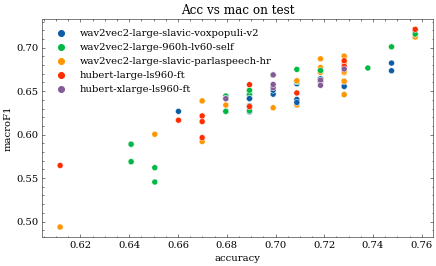

In [168]:
%matplotlib inline
c = df.split == "test"
fig, ax = plt.subplots(figsize=(7, 4))


sns.scatterplot(
    data=df[c],
    x="accuracy",
    y="macroF1",
    hue="model_name_or_path",
    ax = ax
)
ax.legend(
    # ncol=2, 
    loc="upper left"
    )
# ax.set_xlim((0.6, None))
# ax.set_ylim((0.4, None))
ax.set_title("Acc vs mac on test")

plt.show()

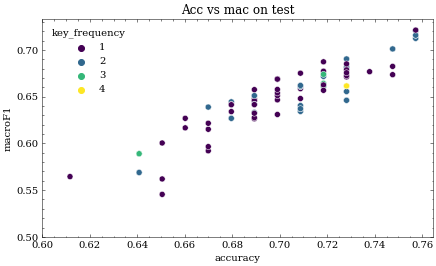

In [169]:
subset = df[df.split=="test"].copy(deep=True)

subset["key"] = subset.apply(lambda row: str(row["accuracy"])+str(row["macroF1"]), axis=1)
vc = subset.key.value_counts()
subset["key_frequency"] = subset.key.apply(lambda s: vc[s])
most_common_key = subset.key.value_counts().index[0]


fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(
    data=subset,
    x="accuracy",
    y="macroF1",
    hue="key_frequency",
    palette="viridis",
    ax = ax
)
ax.set_xlim((0.6, None))

ax.set_ylim((0.5, None))

ax.set_title("Acc vs mac on test")

plt.show()



subset = subset[subset.key == most_common_key]
indices_to_plot = subset.index

In [170]:
df.loc[indices_to_plot].model_name_or_path

31       wav2vec2-large-slavic-voxpopuli-v2
33            wav2vec2-large-960h-lv60-self
151      wav2vec2-large-slavic-voxpopuli-v2
155    wav2vec2-large-slavic-parlaspeech-hr
Name: model_name_or_path, dtype: object

We found 4 results, produced by 3 different models, that have identical metrics. Let's examine their CMs:

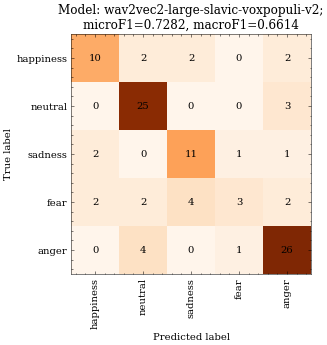

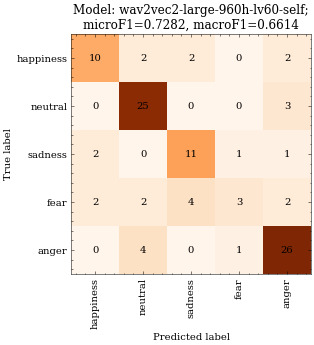

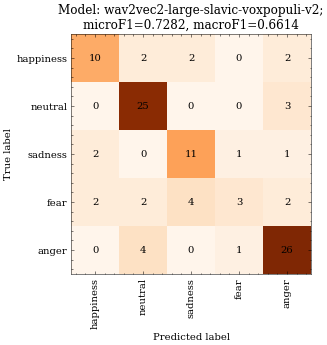

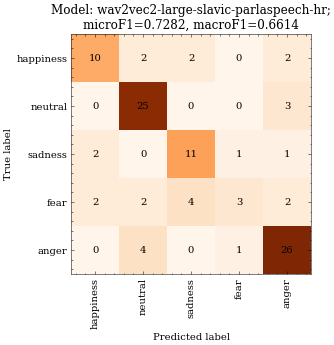

In [171]:
for i, row in df.loc[indices_to_plot].iterrows():
    plot_cm(labels=labels, y_true=row["y_true"], y_pred=row["y_pred"], 
        title=f"Model: {row['model_name_or_path']}",)
    

Are the predictions identical as well?

In [172]:
df.loc[indices_to_plot].y_pred.apply(str).unique().shape[0]

1

Yes, yes they are.

## New approach: 

select 3 models in average performance range and check the predictions:

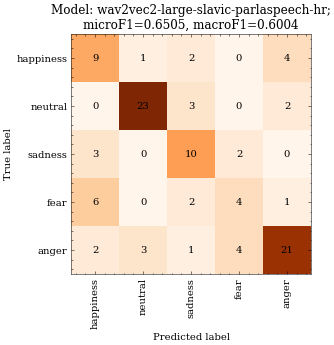

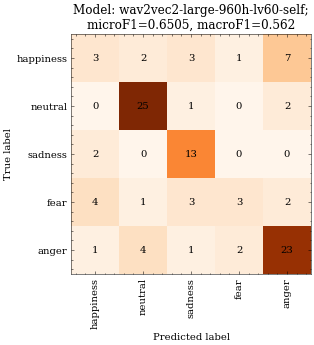

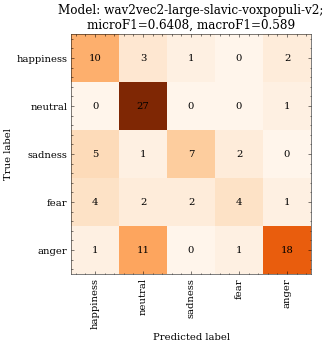

In [173]:
idx = [95, 27, 13]
for i, row in df.loc[idx].iterrows():
    plot_cm(labels=labels, y_true=row["y_true"], y_pred=row["y_pred"], 
        title=f"Model: {row['model_name_or_path']}",)

These predictions are obviously not identical. Let us then see, if models from the plots aree between eachother better than ground truth.:

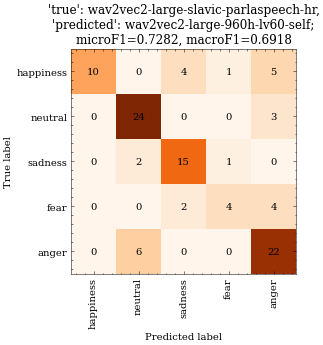

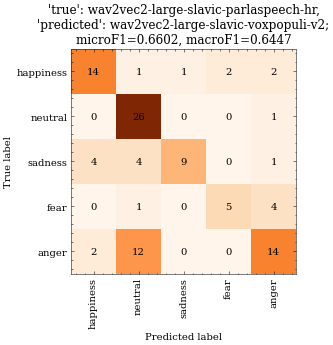

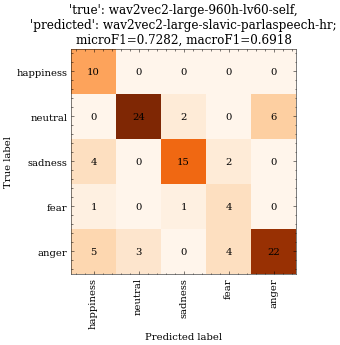

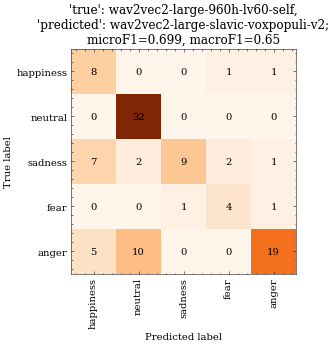

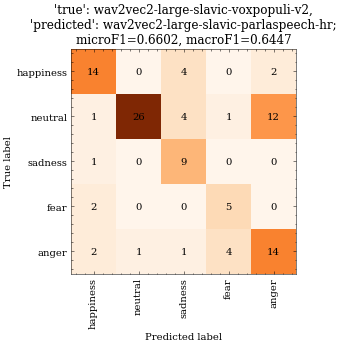

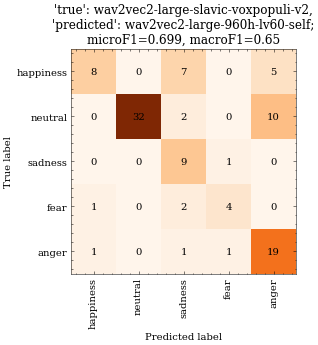

In [174]:
idx = [95, 27, 13]
for i, row1 in df.loc[idx].iterrows():
    first_model = row1['model_name_or_path']
    for j, row2 in df.loc[idx].iterrows():
        if i == j:
            continue
        plot_cm(labels=labels, 
                y_true=row1["y_pred"], 
                y_pred=row2["y_pred"],
                title=f"'true': {first_model},\n'predicted': {row2['model_name_or_path']}",)


General case: what if we calculate macro F1 for every available prediction pair in test case?

In [175]:
subset = df.query("split == 'test'")\
    .sample(10)\
    .sort_values("model_name_or_path")\
    .reset_index(drop=True)
N = subset.shape[0]
import numpy as np
macros = np.empty((N, N), dtype=float)
for i, row in subset.iterrows():
    for j, wade in subset.iterrows():
        macros[i, j] = f1_score(
            y_true = row["y_pred"],
            y_pred = wade["y_pred"],
            labels=labels,
            average="macro"
        )
    


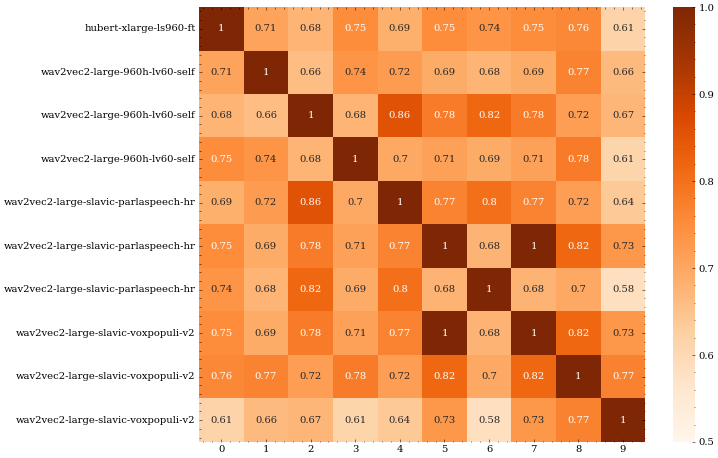

In [176]:
fig, ax = plt.subplots(figsize=(10, 8))


sns.heatmap(macros, annot=True, cmap="Oranges", ax=ax,
            vmin=0.5, 
            yticklabels=subset.model_name_or_path
            )
ax.set_yticklabels(subset.model_name_or_path)

plt.show()


New idea: let's compare performances in three ranges, low, average, and top:

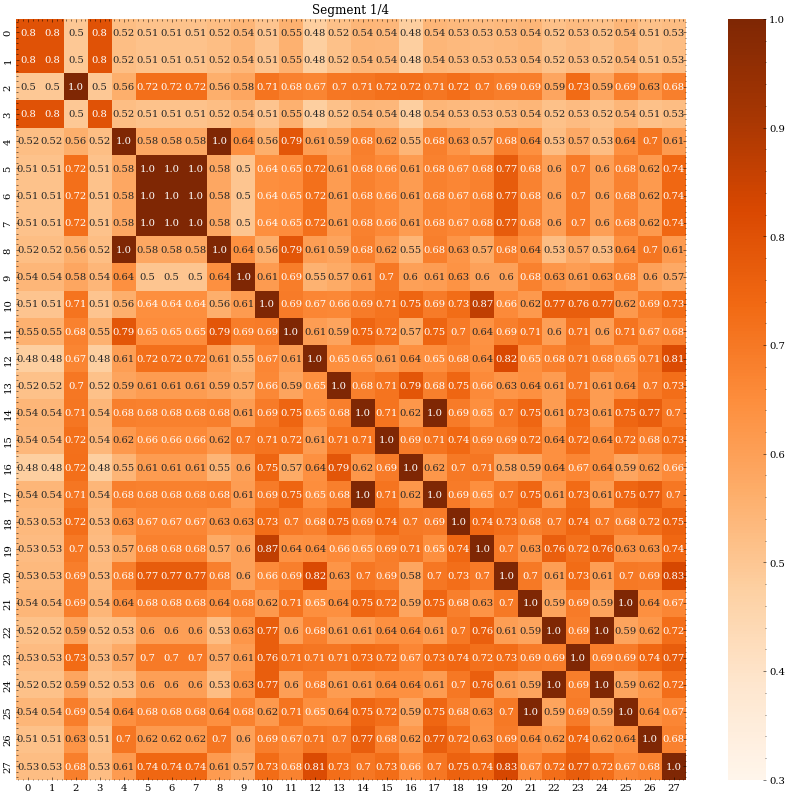

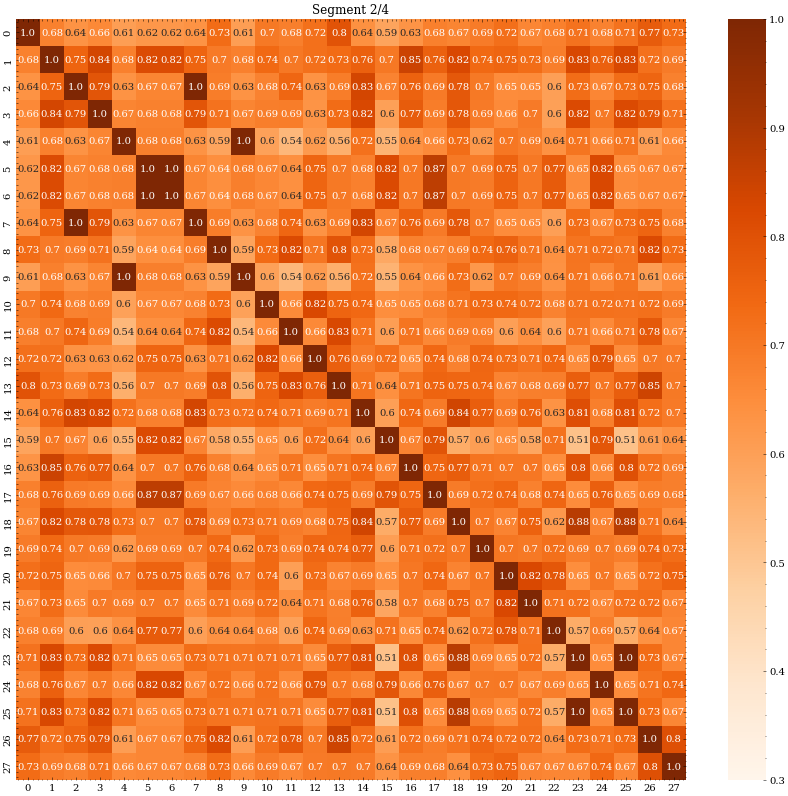

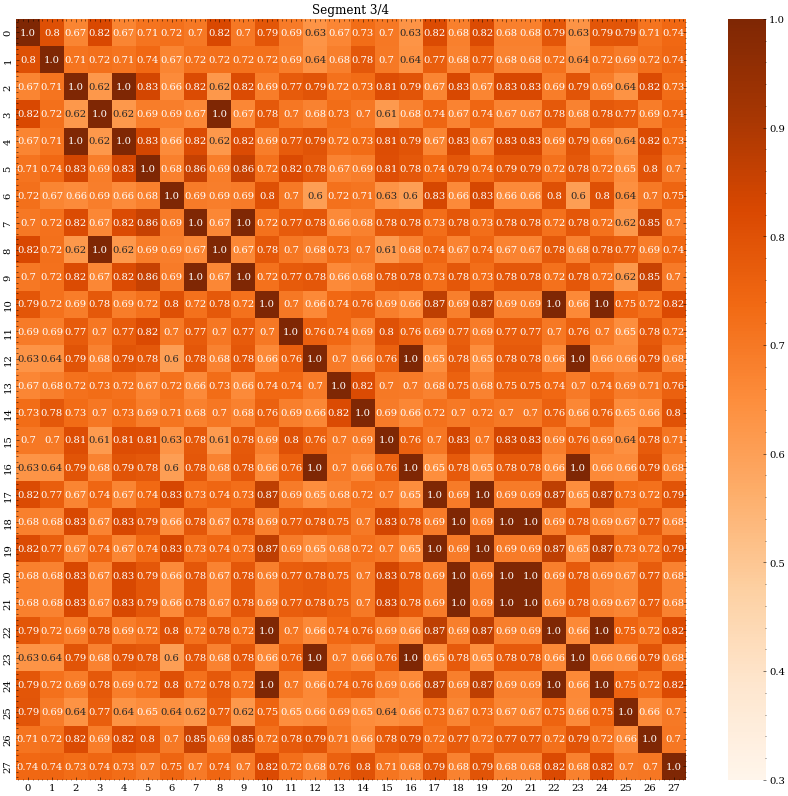

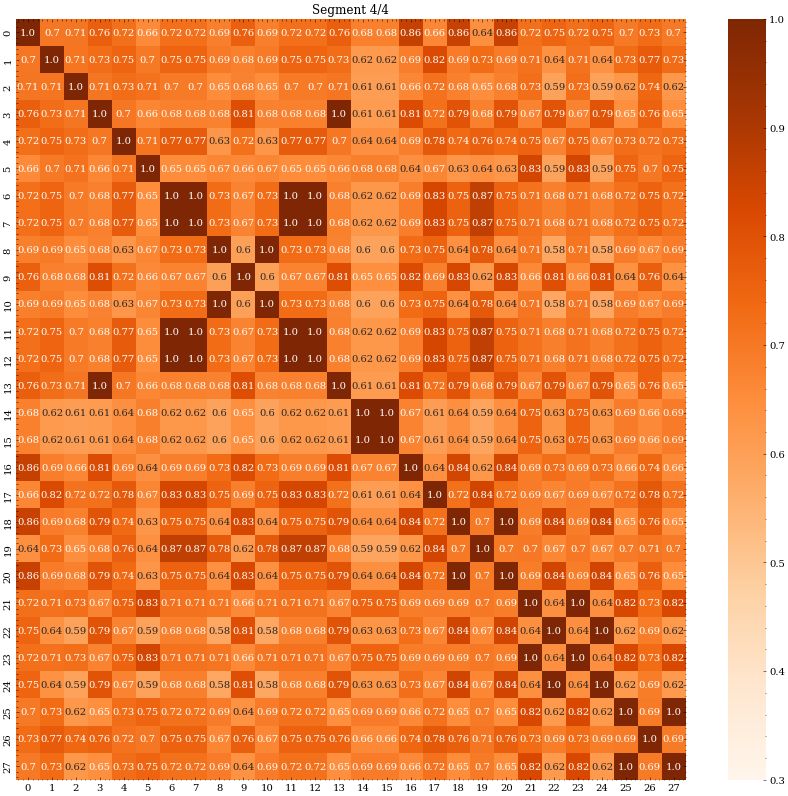

In [177]:
subset = df.query("split == 'test'")\
    .sort_values("accuracy", ascending=True)\
    .reset_index(drop=True)

N = subset.shape[0]

subdivisor = 4
for i in range(subdivisor):
    start = int(N/subdivisor)*i
    end = int(N/subdivisor)*(i+1)

    import numpy as np
    subsubset = subset.loc[start:end+1].reset_index(drop=True)
    M = subsubset.shape[0]
    macros = np.empty((M,M), dtype=float)
    for ii, row in subsubset.iterrows():
        for jj, wade in subsubset.iterrows():
            macros[ii, jj] = f1_score(
                y_true = row["y_pred"],
                y_pred = wade["y_pred"],
                labels=labels,
                average="macro",
                zero_division=0,
            )

    fig, ax = plt.subplots(figsize=(15, 14))
    sns.heatmap(macros, annot=True, fmt="0.2", cmap="Oranges", ax=ax,
                vmin=0.3, vmax=1
                )
    ax.set_title(f"Segment {i+1}/{subdivisor}")
    plt.show()